In [14]:
%matplotlib inline
import os
from glob import glob

import calendar
import numpy as np
import xarray as xr
import xesmf as xe
import dask
import esmlab

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.path as mpath

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import cmocean
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
#style.use('ggplot')

import util
import shutil

In [3]:
ds_djf = xr.open_zarr('data/cesm-le-fields-djf-epoch-mean2.zarr')
ds_djf

<xarray.Dataset>
Dimensions:    (epoch: 2, length: 4, member_id: 34, nlat: 93, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    dz         (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
  * epoch      (epoch) <U9 '1985-2005' '2070-2100'
  * length     (length) float64 20.0 30.0 40.0 50.0
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * z_t        (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
  * z_t_150m   (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf   (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    IFRAC      (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    KGP        (epoch, length, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 17, 47, 160), meta=np.ndarray>
    SST        (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>

In [8]:
# Lat Lon Checks
lon = ds_djf.TLONG.values
lat = ds_djf.TLAT.values
# Basic Means
kgp_mean = ds_djf['KGP'].mean('member_id')
sst_mean = ds_djf['SST'].mean('member_id')
chl_mean = ds_djf['Chl_surf'].mean('member_id')
ice_mean = ds_djf['IFRAC'].mean('member_id')

In [11]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

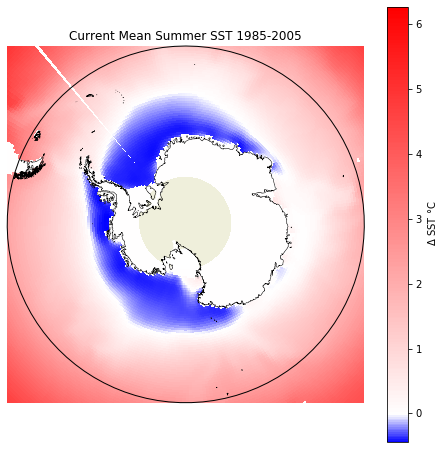

In [35]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Current Mean Summer SST 1985-2005')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, sst_mean.sel(epoch = '1985-2005'), cmap='bwr', norm=MidpointNormalize(midpoint=0.),
                 #vmin = -1, vmax = 6,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label=' $\Delta$ SST °C')
    
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)



In [33]:
## Trying to make things look better
ds_cyclic = util.pop_add_cyclic(sst_mean)

NotImplementedError: Item assignment with <class 'tuple'> not supported

In [ ]:
#PLOT IT
dsp = util.pop_add_cyclic(dsmod)

lon, lat = dsp.TLONG.isel(nlat=slice(0, 100)), dsp.TLAT.isel(nlat=slice(0, 100)) 
field = dsp.Chl_surf.isel(month=11, nlat=slice(0, 100))
#field = np.log(dsp.Chl_surf.isel(month=0, nlat=slice(0, 100)))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -75,  -50], crs=ccrs.PlateCarree())

cmap = cmocean.cm.haline
#levels = np.logspace(-2, 1, 16)
levels=[-0.043, 0, 0.0028, 0.066]


#norm = colors.LogNorm(vmin=0.01, vmax=20.)
#norm = colors.LogNorm(vmin=-0.043, vmax=0.066)


cf = ax.contourf(lon, lat, field,
                 levels=levels,
                 cmap=cmap,
                 extend='both',
#                 norm=norm,
#                 vmin=-0.043, vmax=0.066,
                 transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines().n_steps = 90  ## this makes them rounder
#plt.title('January Model Output np.log ')
plt.title('December: Model 1986 - 2005')

#plt.title('January Model Output')
fig.colorbar(cf, ax=ax)
#plt.savefig('January-CESM-Chl-map.png')

In [22]:
## KGP is positive wrt SST
test = ds_djf['SST'].where((-1. <= ds_djf['SST']) & (ds_djf['SST'] <= 5.)).fillna(0.).where(ds_djf.KMT > 0)
test

<xarray.DataArray 'SST' (epoch: 2, member_id: 34, nlat: 93, nlon: 320)>
dask.array<where, shape=(2, 34, 93, 320), dtype=float64, chunksize=(1, 9, 47, 160), chunktype=numpy.ndarray>
Coordinates:
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * epoch      (epoch) <U9 '1985-2005' '2070-2100'
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Potential Temperature
    units:         degC

In [27]:
test_mean = test.mean('member_id')


/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


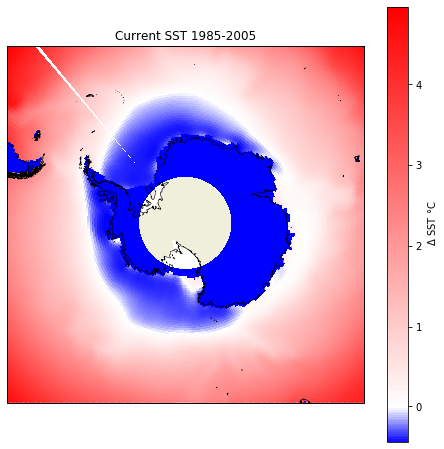

In [30]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Current SST 1985-2005')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, test_mean.sel(epoch = '1985-2005'), cmap='bwr', norm=MidpointNormalize(midpoint=0.),
                 #vmin = -1, vmax = 6,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label=' $\Delta$ SST °C')


In [26]:
test.sel(epoch = '1985-2005')

<xarray.DataArray 'SST' (member_id: 34, nlat: 93, nlon: 320)>
dask.array<getitem, shape=(34, 93, 320), dtype=float64, chunksize=(9, 47, 160), chunktype=numpy.ndarray>
Coordinates:
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    epoch      <U9 '1985-2005'
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Potential Temperature
    units:         degC